# Chapter 4.2

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics
import time

In [3]:
import tensorflow.keras as keras
from keras.backend import clear_session
import gc

# Reset Keras Session
def reset_keras():
    clear_session()
    print(gc.collect())
    print(gc.collect())

Using TensorFlow backend.


## Self-created functions

In [4]:
def estimate_node_importance(model, tester_model, layer_sizes, tol_low, tol_high, x, y):
    
    l, a = model.evaluate(x, y, verbose=0, batch_size=256)
    or_weights = model.get_weights()
    weight_len = len(or_weights) - 3
    num_zeros, num_worse, num_important = (0, 0, 0)
    z = []
    wr = []
    imp = []
    amounts = []
    places = []
    avg_imp = np.zeros(len(layer_sizes))
    avg_zero = np.zeros(len(layer_sizes))
    avg_wr = np.zeros(len(layer_sizes))
    for layer, size in enumerate(layer_sizes):
        num_zeros, num_worse, num_important = (0, 0, 0)
        z = []
        wr = []
        imp = []
        for i in range(size):
            w = copy.deepcopy(or_weights)
            w[weight_len - (2*layer+1)][...,i] = 0
            w[weight_len - 2*layer][i] = 0
            tester_model.set_weights(w)
            nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
            change = l - nl
            if change <= tol_high and change >= tol_low:
                num_zeros += 1
                z += [i]
                avg_zero[layer] += change
            elif change > 0:
                num_worse += 1
                wr += [i]
                avg_wr[layer] += change
            else:
                num_important += 1
                imp += [i]
                avg_imp[layer] += change
        amounts.append((num_zeros, num_worse, num_important))
        places.append((z, wr, imp))
        
        if num_important > 0:
            avg_imp[layer] /= num_important
        if num_zeros > 0:
            avg_zero[layer] /= num_zeros
        if num_worse > 0:
            avg_wr[layer] /= num_worse
    
    return amounts, places, avg_imp, avg_zero, avg_wr

## Single-layer ANN

### MNIST

In [5]:
np.random.seed(2020)

In [6]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [8]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
dropout_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
node_importance = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
accs = np.zeros((trials, len(dropout_rate)))
losses = np.zeros((trials, len(dropout_rate)))
avg_node_imp = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
for b, rate in enumerate(dropout_rate):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(rate),
                tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [06:13<00:00, 14.93s/it]


In [11]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI.to_csv('../../../results/dropout/node_imp_ANN_dropout_mnist.csv')
NI.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count   25.00000   25.000000       25.000000  25.000000   25.000000   
mean     2.20000   23.680000      102.120000   2.600000   23.240000   
std      1.47196    5.757025        5.703215   1.658312    7.189576   
min      0.00000   13.000000       85.000000   0.000000    8.000000   
25%      1.00000   21.000000      100.000000   2.000000   19.000000   
50%      2.00000   24.000000      103.000000   2.000000   22.000000   
75%      3.00000   25.000000      105.000000   3.000000   30.000000   
max      6.00000   41.000000      110.000000   7.000000   36.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean       102.160000   3.360000   25.520000       99.120000   4.240000   
std          7.215031   1.868154    5.116314        5.725091   1.786057   
min         91.000000   1.000000   14.000000       89.000000   1.000000   
25%         96.000000   1.000000   22.000000       94.000000   3.000000   
50%        104.000000   4.000000   27.000000       99.000000   4.000000   
75%        105.000000   4.000000   29.000000      103.000000   6.000000   
max        120.000000   7.000000   33.000000      113.000000   7.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000   25.00000       25.00       25.000000  
mean    32.320000       91.440000    9.16000        5.32      113.520000  
std      7.425856        6.934695    2.30362        4.10        5.025933  
min     21.000000       77.000000    4.00000        1.00      101.000000  
25%     27.000000       87.000000    8.00000        3.00      112.000000  
50%     32.000000       93.000000    9.00000        4.00      115.000000  
75%     38.000000       95.000000   11.00000        6.00      116.000000  
max     45.000000      102.000000   14.00000       17.00      122.000000

In [12]:
AvgNI = pd.DataFrame(avg_node_imp.reshape(trials, -1), columns=index)
AvgNI.to_csv('../../../results/dropout/avg_node_imp_ANN_dropout_mnist.csv')
AvgNI.describe()

0.1                                       0.3              \
      Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  2.500000e+01   25.000000   
mean   -0.000002    0.000523       -0.001256  5.262522e-07    0.000424   
std     0.000003    0.000220        0.000184  2.717233e-06    0.000148   
min    -0.000010    0.000247       -0.001883 -5.640090e-06    0.000197   
25%    -0.000003    0.000368       -0.001293 -2.607703e-08    0.000308   
50%     0.000000    0.000488       -0.001222  0.000000e+00    0.000388   
75%     0.000000    0.000694       -0.001171  8.009374e-07    0.000543   
max     0.000004    0.001057       -0.001037  6.583830e-06    0.000691   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.000852 -3.027100e-07    0.000353       -0.000685  8.373033e-08   
std          0.000100  3.222619e-06    0.000114        0.000083  1.540701e-06   
min         -0.001069 -8.426607e-06    0.000196       -0.000890 -3.308058e-06   
25%         -0.000916 -1.044146e-06    0.000257       -0.000735 -1.085656e-07   
50%         -0.000831  0.000000e+00    0.000316       -0.000664  0.000000e+00   
75%         -0.000779  5.345792e-07    0.000445       -0.000633  8.255243e-07   
max         -0.000714  9.559095e-06    0.000569       -0.000554  3.889203e-06   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000358       -0.000616 -7.568757e-08    0.000216       -0.001253  
std      0.000088        0.000064  5.118898e-07    0.000129        0.000104  
min      0.000181       -0.000731 -1.569589e-06    0.000045       -0.001475  
25%      0.000294       -0.000664 -1.463023e-07    0.000124       -0.001319  
50%      0.000363       -0.000618 -6.622738e-09    0.000207       -0.001241  
75%      0.000416       -0.000583  7.450581e-09    0.000236       -0.001175  
max      0.000517       -0.000482  1.009968e-06    0.000595       -0.001073

In [13]:
A = pd.DataFrame(accs, columns=dropout_rate)
A.to_csv('../../../results/dropout/avg_acc_ANN_dropout_mnist.csv')
A.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.976096,0.974948,0.971024,0.960644,0.929336
std,0.001487,0.001185,0.000955,0.001299,0.002219
min,0.971000,0.972300,0.968900,0.957900,0.924200
25%,0.975500,0.974200,0.970500,0.959700,0.928400
50%,0.976400,0.974800,0.971000,0.960900,0.929900
75%,0.977100,0.975900,0.971700,0.961700,0.930800
max,0.977500,0.976700,0.972500,0.962900,0.933400


In [14]:
L = pd.DataFrame(losses, columns=dropout_rate)
L.to_csv('../../../results/dropout/loss_ANN_dropout_mnist.csv')
L.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.077474,0.082169,0.096186,0.133321,0.271423
std,0.004363,0.003260,0.002727,0.003178,0.007561
min,0.071275,0.075276,0.091340,0.126131,0.261164
25%,0.074962,0.080244,0.094373,0.131304,0.264082
50%,0.076453,0.081934,0.095708,0.133104,0.271017
75%,0.079676,0.084187,0.098168,0.136295,0.274889
max,0.092482,0.089256,0.103436,0.139275,0.292647


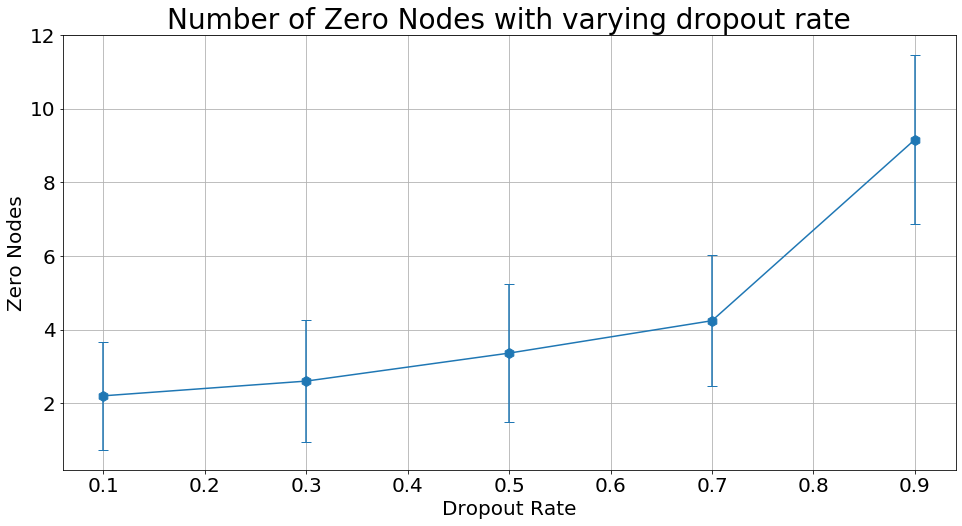

In [15]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Zero Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/zero_nodes_ANN_dropout_mnist.png")

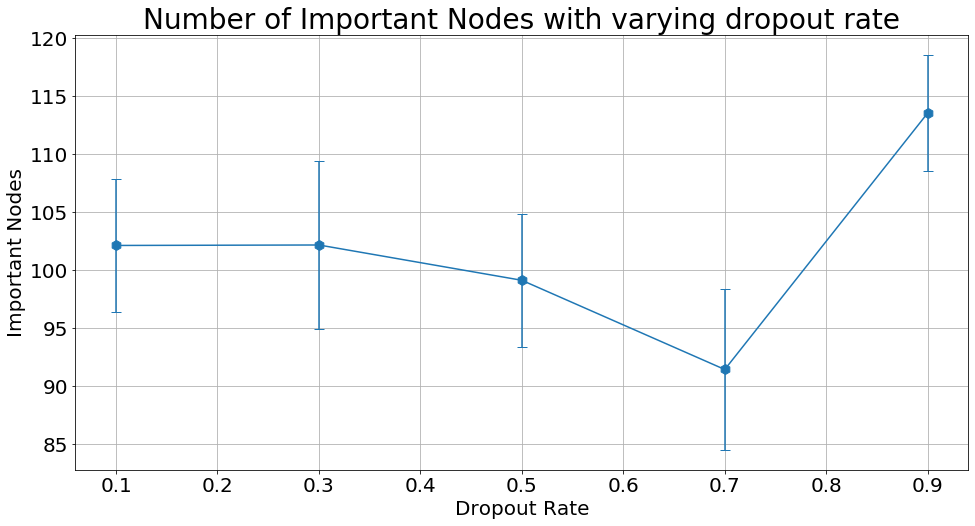

In [16]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Important Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/imp_nodes_ANN_dropout_mnist.png")

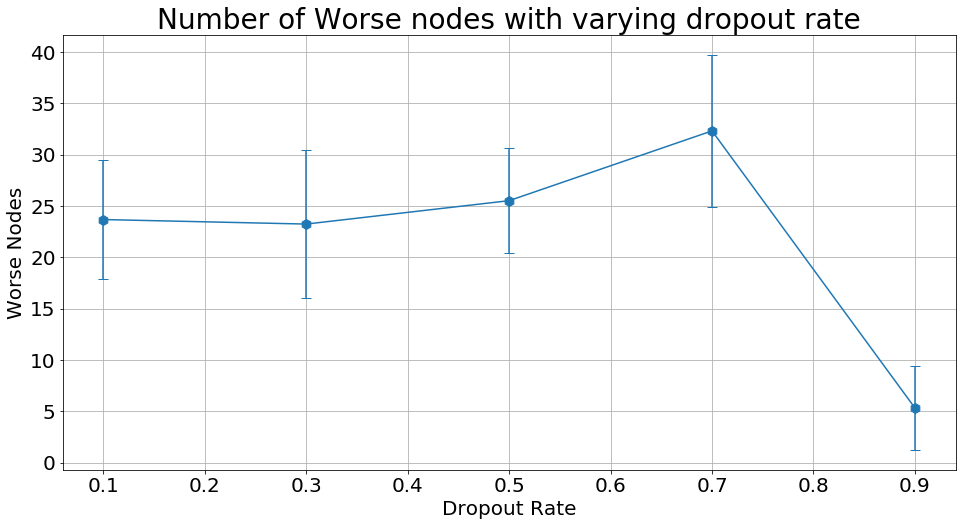

In [17]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/worse_nodes_ANN_dropout_mnist.png")

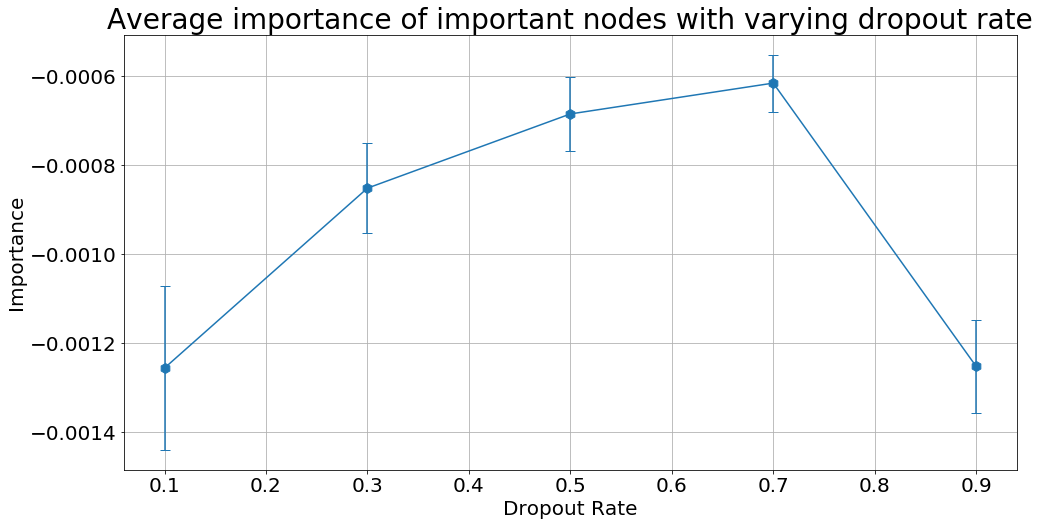

In [18]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average importance of important nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/avg_imp_nodes_ANN_dropout_mnist.png")

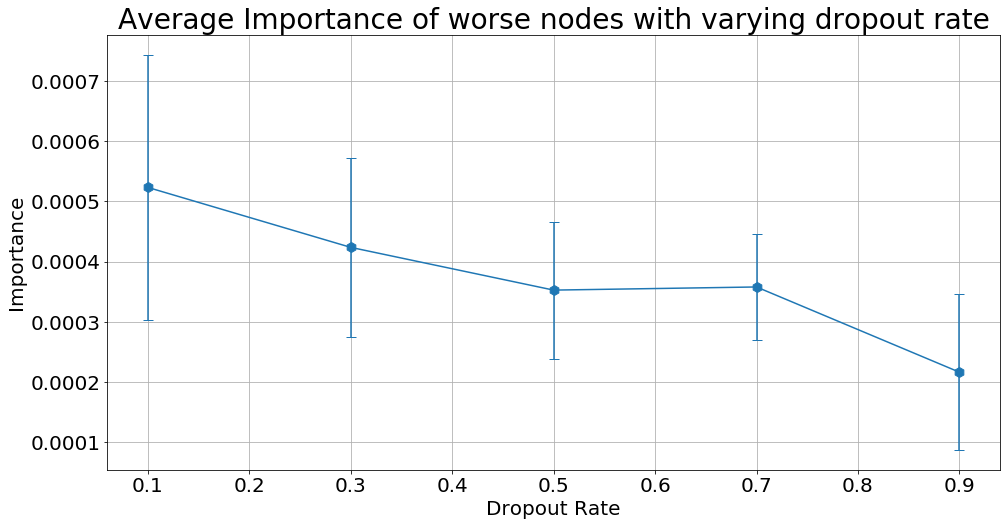

In [19]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average Importance of worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/avg_worse_nodes_ANN_dropout_mnist.png")

### Fashion MNIST

In [20]:
np.random.seed(2020)

In [21]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [22]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [23]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
dropout_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
node_importance = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
accs = np.zeros((trials, len(dropout_rate)))
losses = np.zeros((trials, len(dropout_rate)))
avg_node_imp = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
for b, rate in enumerate(dropout_rate):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(rate),
                tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [06:14<00:00, 14.97s/it]


In [25]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI.to_csv('../../../results/dropout/node_imp_ANN_dropout_fmnist.csv')
NI.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000    25.00000       25.000000  25.000000   25.000000   
mean   15.040000    29.20000       83.760000  16.680000   28.640000   
std     3.115552     6.22495        6.759438   3.782856    6.879196   
min     7.000000    16.00000       66.000000  10.000000   13.000000   
25%    14.000000    24.00000       82.000000  13.000000   23.000000   
50%    15.000000    30.00000       84.000000  17.000000   29.000000   
75%    17.000000    32.00000       86.000000  18.000000   32.000000   
max    23.000000    41.00000       97.000000  24.000000   43.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        82.680000  19.400000   26.400000       82.200000  22.120000   
std          6.433765   5.212165    9.013878        7.691987   3.539303   
min         71.000000  11.000000   14.000000       64.000000  17.000000   
25%         78.000000  16.000000   22.000000       77.000000  20.000000   
50%         82.000000  20.000000   26.000000       82.000000  22.000000   
75%         85.000000  22.000000   29.000000       88.000000  24.000000   
max         97.000000  33.000000   51.000000       97.000000  30.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000        25.00000  
mean    25.560000       80.320000  37.720000    5.360000        84.92000  
std      8.206095        9.200181   4.587301    3.706751         3.31562  
min     14.000000       61.000000  26.000000    0.000000        80.00000  
25%     19.000000       74.000000  36.000000    3.000000        82.00000  
50%     23.000000       83.000000  38.000000    5.000000        85.00000  
75%     31.000000       89.000000  41.000000    7.000000        87.00000  
max     42.000000       91.000000  45.000000   14.000000        93.00000

In [26]:
AvgNI = pd.DataFrame(avg_node_imp.reshape(trials, -1), columns=index)
AvgNI.to_csv('../../../results/dropout/avg_node_imp_ANN_dropout_fmnist.csv')
AvgNI.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -9.755117e-08    0.001266       -0.001866  3.190721e-08    0.000950   
std    5.553855e-07    0.000647        0.000419  3.849615e-07    0.000393   
min   -1.206001e-06    0.000267       -0.002921 -6.599086e-07    0.000168   
25%   -4.152457e-07    0.000815       -0.001985 -3.495000e-07    0.000693   
50%   -1.928386e-07    0.001109       -0.001870  0.000000e+00    0.000949   
75%    3.129244e-08    0.001552       -0.001596  3.402432e-07    0.001149   
max    1.739178e-06    0.002793       -0.001154  9.347092e-07    0.002006   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.001266 -9.381741e-08    0.000740       -0.001110  2.263569e-08   
std          0.000131  3.552821e-07    0.000278        0.000142  3.329673e-07   
min         -0.001500 -8.669767e-07    0.000301       -0.001437 -1.008020e-06   
25%         -0.001358 -3.121401e-07    0.000512       -0.001158 -1.537800e-07   
50%         -0.001270 -4.257475e-08    0.000750       -0.001099  5.442163e-08   
75%         -0.001177  3.897227e-08    0.000925       -0.001003  1.523230e-07   
max         -0.001018  7.152557e-07    0.001323       -0.000815  5.648250e-07   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000501       -0.000994  2.749836e-08    0.000277       -0.002156  
std      0.000221        0.000151  1.144619e-07    0.000204        0.000252  
min      0.000206       -0.001288 -1.933517e-07    0.000000       -0.002691  
25%      0.000354       -0.001105 -1.986821e-08    0.000160       -0.002300  
50%      0.000468       -0.000978  2.094217e-08    0.000223       -0.002150  
75%      0.000655       -0.000869  4.023314e-08    0.000313       -0.002036  
max      0.001188       -0.000745  4.804496e-07    0.000918       -0.001546

In [27]:
A = pd.DataFrame(accs, columns=dropout_rate)
A.to_csv('../../../results/dropout/avg_acc_ANN_dropout_fmnist.csv')
A.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.869708,0.867412,0.859900,0.847096,0.781256
std,0.004080,0.002949,0.003678,0.003444,0.014396
min,0.859600,0.860600,0.851700,0.840400,0.739200
25%,0.867700,0.866500,0.858100,0.845200,0.780700
50%,0.870600,0.868000,0.860000,0.847200,0.785500
75%,0.872600,0.869300,0.862200,0.849800,0.789400
max,0.874700,0.873000,0.866000,0.852200,0.800600


In [28]:
L = pd.DataFrame(losses, columns=dropout_rate)
L.to_csv('../../../results/dropout/loss_ANN_dropout_fmnist.csv')
L.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.361021,0.368142,0.388904,0.423456,0.610943
std,0.012419,0.006716,0.007435,0.005755,0.012095
min,0.345039,0.358989,0.376424,0.412042,0.584422
25%,0.354645,0.363063,0.384835,0.419991,0.603218
50%,0.356508,0.367384,0.388200,0.423203,0.612765
75%,0.365038,0.371388,0.392072,0.427789,0.618896
max,0.404806,0.385859,0.408290,0.434945,0.633426


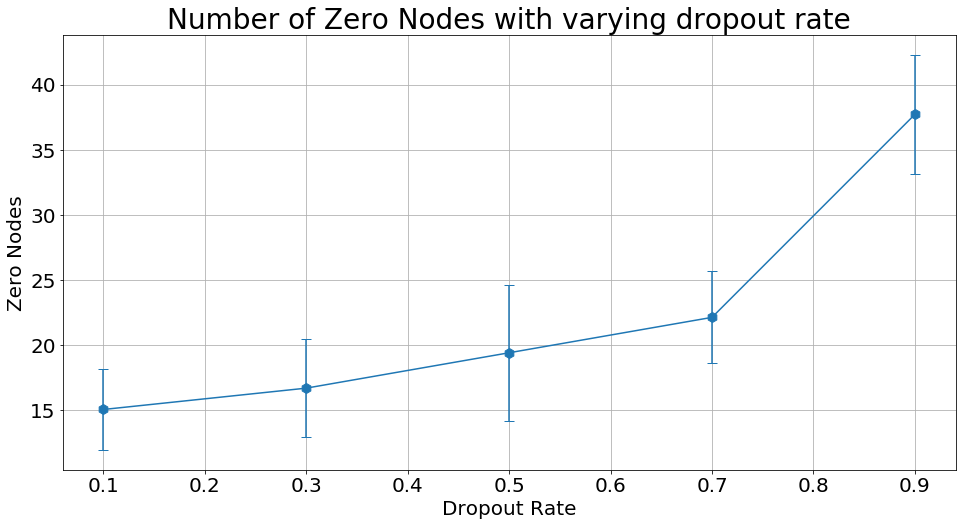

In [29]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Zero Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/zero_nodes_ANN_dropout_fmnist.png")

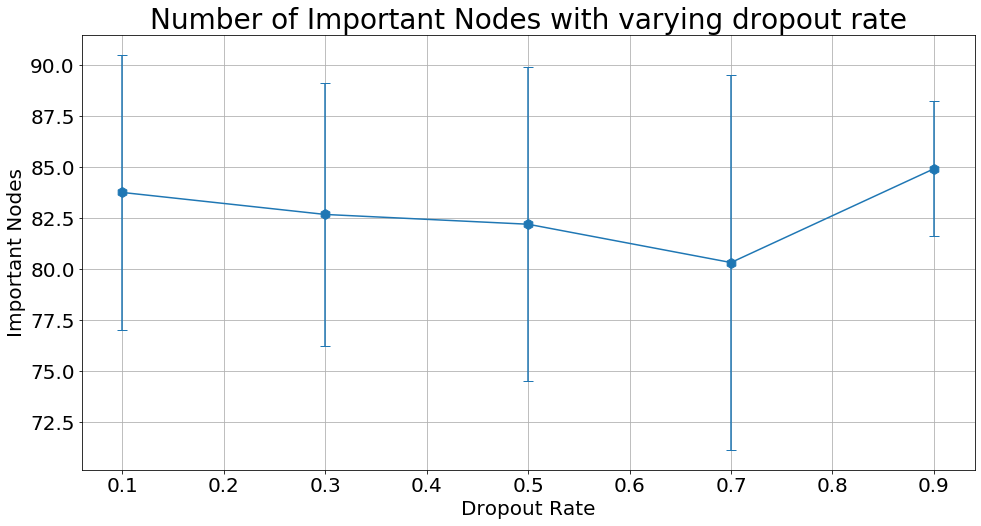

In [30]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Important Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/imp_nodes_ANN_dropout_fmnist.png")

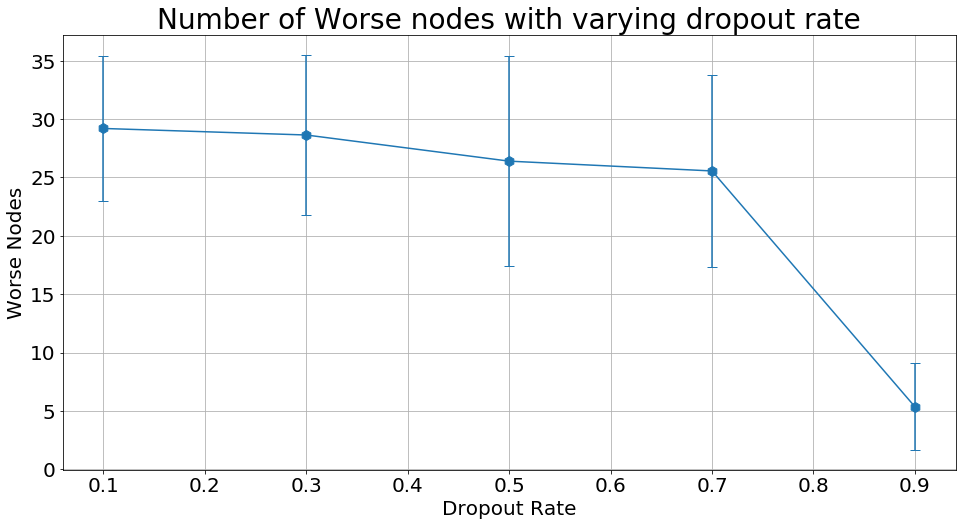

In [31]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/worse_nodes_ANN_dropout_fmnist.png")

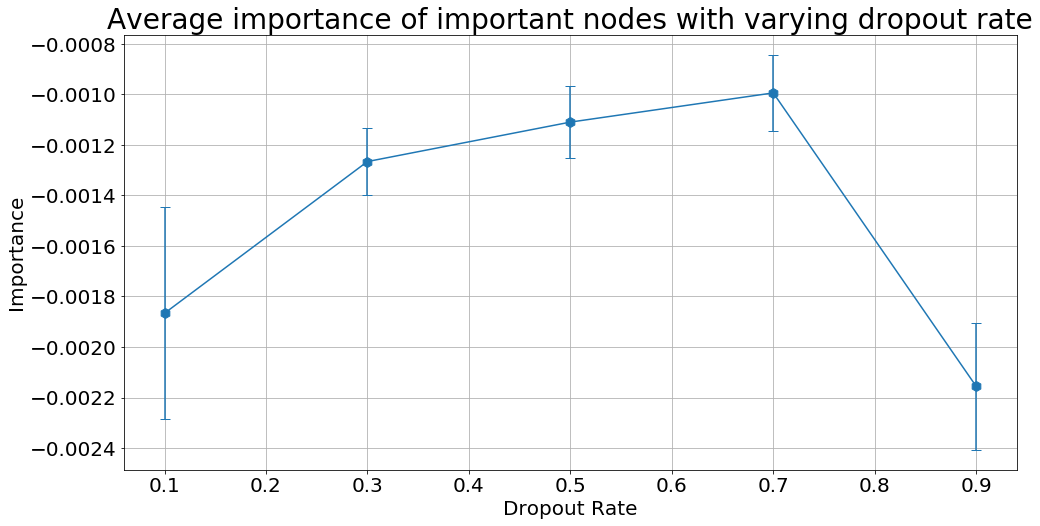

In [32]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average importance of important nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/avg_imp_nodes_ANN_dropout_fmnist.png")

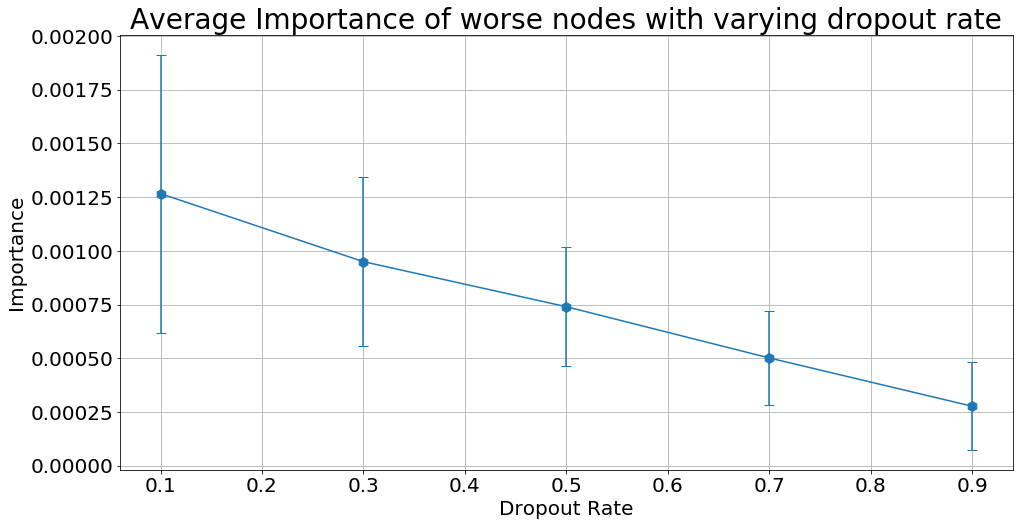

In [33]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average Importance of worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/avg_worse_nodes_ANN_dropout_fmnist.png")

## Multi-layer Perceptron

### MNIST

In [34]:
np.random.seed(2020)

In [35]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [36]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [37]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
dropout_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
node_importance = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
accs = np.zeros((trials, len(dropout_rate)))
losses = np.zeros((trials, len(dropout_rate)))
avg_node_imp = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
for b, rate in enumerate(dropout_rate):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [09:26<00:00, 22.67s/it]


In [39]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_1 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/dropout/node_imp_MLP_dropout_1_mnist.csv')
NI_1.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count       25.0   25.000000        25.00000  25.000000   25.000000   
mean         3.8   30.720000        93.48000   5.680000   34.760000   
std          2.0    6.667833         5.64299   2.528504    6.540133   
min          1.0   15.000000        82.00000   0.000000   25.000000   
25%          3.0   26.000000        91.00000   5.000000   31.000000   
50%          3.0   28.000000        95.00000   5.000000   34.000000   
75%          5.0   35.000000        97.00000   7.000000   37.000000   
max          9.0   45.000000       104.00000  11.000000   57.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        87.560000  14.920000   38.920000       74.160000  59.080000   
std          6.500513   3.650571    6.951738        5.595236   5.529617   
min         68.000000  10.000000   25.000000       60.000000  49.000000   
25%         84.000000  12.000000   35.000000       72.000000  55.000000   
50%         87.000000  14.000000   39.000000       74.000000  60.000000   
75%         92.000000  18.000000   43.000000       77.000000  63.000000   
max         99.000000  21.000000   54.000000       84.000000  69.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000   25.00000       25.00       25.000000  
mean    23.280000       45.640000  127.68000        0.04        0.280000  
std      7.003095        7.227724    1.10755        0.20        0.979796  
min      8.000000       35.000000  124.00000        0.00        0.000000  
25%     19.000000       39.000000  128.00000        0.00        0.000000  
50%     24.000000       46.000000  128.00000        0.00        0.000000  
75%     27.000000       51.000000  128.00000        0.00        0.000000  
max     39.000000       62.000000  128.00000        1.00        4.000000

In [40]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/dropout/avg_node_imp_MLP_dropout_1_mnist.csv')
AvgNI_1.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -6.753102e-07    0.000687       -0.001395  1.650847e-07    0.000645   
std    2.477275e-06    0.000249        0.000228  8.118336e-07    0.000193   
min   -7.882714e-06    0.000304       -0.002176 -1.667440e-06    0.000304   
25%   -6.500632e-07    0.000485       -0.001489 -2.980232e-09    0.000509   
50%    0.000000e+00    0.000649       -0.001343  1.241763e-09    0.000688   
75%    2.522554e-07    0.000872       -0.001247  6.332994e-07    0.000763   
max    2.883375e-06    0.001307       -0.001095  1.925443e-06    0.001033   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.000992 -4.511120e-08    0.000711       -0.001067 -3.026122e-08   
std          0.000146  4.588711e-07    0.000118        0.000122  1.441408e-07   
min         -0.001394 -9.082613e-07    0.000544       -0.001296 -3.139888e-07   
25%         -0.001032 -2.441498e-07    0.000612       -0.001153 -1.428456e-07   
50%         -0.000984 -1.170806e-08    0.000715       -0.001044 -1.490116e-08   
75%         -0.000902  2.905726e-07    0.000777       -0.001016  6.082107e-08   
max         -0.000764  9.735425e-07    0.001019       -0.000754  2.260478e-07   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000792       -0.002682  1.023854e-09    0.000005       -0.000285  
std      0.000291        0.000953  1.000270e-08    0.000025        0.000987  
min      0.000267       -0.004368 -1.303852e-08    0.000000       -0.003663  
25%      0.000643       -0.003237 -1.862645e-09    0.000000        0.000000  
50%      0.000779       -0.002655  0.000000e+00    0.000000        0.000000  
75%      0.000960       -0.001875  0.000000e+00    0.000000        0.000000  
max      0.001523       -0.001254  4.422280e-08    0.000123        0.000000

In [41]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_2 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/dropout/node_imp_MLP_dropout_2_mnist.csv')
NI_2.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000      25.000       25.000000  25.000000   25.000000   
mean    0.680000      22.360       40.960000   0.920000   27.320000   
std     0.748331       4.999        5.127377   0.862168    5.459853   
min     0.000000      13.000       29.000000   0.000000   16.000000   
25%     0.000000      19.000       38.000000   0.000000   24.000000   
50%     1.000000      21.000       42.000000   1.000000   27.000000   
75%     1.000000      26.000       45.000000   1.000000   32.000000   
max     2.000000      33.000       51.000000   3.000000   37.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000        25.00000  25.000000   
mean        35.760000   0.400000   33.800000        29.80000   0.560000   
std          5.456495   0.707107    6.934215         7.00595   0.768115   
min         27.000000   0.000000   18.000000        20.00000   0.000000   
25%         32.000000   0.000000   27.000000        24.00000   0.000000   
50%         35.000000   0.000000   36.000000        27.00000   0.000000   
75%         39.000000   1.000000   40.000000        36.00000   1.000000   
max         48.000000   2.000000   44.000000        46.00000   2.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean    20.200000       43.240000  61.480000    0.560000        1.960000  
std      8.995369        9.189124   8.471127    1.938212        6.573178  
min      4.000000       18.000000  28.000000    0.000000        0.000000  
25%     15.000000       38.000000  64.000000    0.000000        0.000000  
50%     19.000000       44.000000  64.000000    0.000000        0.000000  
75%     26.000000       49.000000  64.000000    0.000000        0.000000  
max     44.000000       60.000000  64.000000    9.000000       27.000000

In [42]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/dropout/avg_node_imp_MLP_dropout_2_mnist.csv')
AvgNI_2.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean   2.472103e-07    0.000896       -0.001195  8.552770e-07    0.000693   
std    3.450241e-06    0.000314        0.000272  3.073821e-06    0.000211   
min   -8.270144e-06    0.000291       -0.001752 -5.200505e-06    0.000315   
25%    0.000000e+00    0.000785       -0.001348  0.000000e+00    0.000512   
50%    0.000000e+00    0.000890       -0.001148  0.000000e+00    0.000700   
75%    7.376075e-07    0.001018       -0.000995  2.652407e-06    0.000823   
max    7.431954e-06    0.001837       -0.000642  6.258488e-06    0.001207   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.000680  2.089143e-07    0.000579       -0.000567 -8.618832e-07   
std          0.000170  2.789319e-06    0.000145        0.000103  2.931832e-06   
min         -0.001023 -9.968877e-06    0.000273       -0.000763 -9.953976e-06   
25%         -0.000805  0.000000e+00    0.000505       -0.000643  0.000000e+00   
50%         -0.000685  0.000000e+00    0.000571       -0.000555  0.000000e+00   
75%         -0.000569  0.000000e+00    0.000657       -0.000477  0.000000e+00   
max         -0.000404  6.504357e-06    0.000891       -0.000388  2.443790e-06   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000654       -0.001771 -1.562060e-08    0.000008       -0.000045  
std      0.000291        0.000645  1.078095e-07    0.000025        0.000154  
min      0.000140       -0.003159 -4.512923e-07    0.000000       -0.000560  
25%      0.000479       -0.002215  0.000000e+00    0.000000        0.000000  
50%      0.000675       -0.001863  0.000000e+00    0.000000        0.000000  
75%      0.000780       -0.001170  0.000000e+00    0.000000        0.000000  
max      0.001629       -0.000820  1.680656e-07    0.000110        0.000000

In [43]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_3 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/dropout/node_imp_MLP_dropout_3_mnist.csv')
NI_3.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000      25.00   25.000000   
mean    0.560000    9.440000       22.000000       0.04   12.800000   
std     0.583095    3.069745        3.201562       0.20    4.041452   
min     0.000000    3.000000       17.000000       0.00    3.000000   
25%     0.000000    7.000000       20.000000       0.00   11.000000   
50%     1.000000   10.000000       21.000000       0.00   13.000000   
75%     1.000000   11.000000       25.000000       0.00   15.000000   
max     2.000000   14.000000       29.000000       1.00   21.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        19.160000   0.080000   12.560000       19.360000   0.120000   
std          4.017462   0.276887    4.831149        4.838044   0.439697   
min         11.000000   0.000000    5.000000       10.000000   0.000000   
25%         17.000000   0.000000    8.000000       16.000000   0.000000   
50%         19.000000   0.000000   13.000000       19.000000   0.000000   
75%         21.000000   0.000000   16.000000       23.000000   0.000000   
max         29.000000   1.000000   22.000000       27.000000   2.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count        25.0       25.000000   25.00000       25.00        25.00000  
mean          5.4       26.480000   30.92000        0.04         1.04000  
std           4.0        4.022023    3.31562        0.20         3.32265  
min           0.0       17.000000   19.00000        0.00         0.00000  
25%           2.0       24.000000   32.00000        0.00         0.00000  
50%           5.0       27.000000   32.00000        0.00         0.00000  
75%           7.0       30.000000   32.00000        0.00         0.00000  
max          15.0       32.000000   32.00000        1.00        13.00000

In [44]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/dropout/avg_node_imp_MLP_dropout_3_mnist.csv')
AvgNI_3.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -4.401803e-07    0.001125       -0.001731 -3.328919e-07    0.000845   
std    2.708407e-06    0.000401        0.000474  1.664460e-06    0.000326   
min   -9.462237e-06    0.000432       -0.002855 -8.322299e-06    0.000161   
25%    0.000000e+00    0.000829       -0.001898  0.000000e+00    0.000668   
50%    0.000000e+00    0.001180       -0.001694  0.000000e+00    0.000823   
75%    0.000000e+00    0.001385       -0.001366  0.000000e+00    0.001006   
max    3.635883e-06    0.002072       -0.000900  0.000000e+00    0.001652   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.001007  5.966425e-07    0.000833       -0.001111  2.384186e-09   
std          0.000211  2.113394e-06    0.000333        0.000231  1.192093e-08   
min         -0.001383  0.000000e+00    0.000381       -0.001734  0.000000e+00   
25%         -0.001184  0.000000e+00    0.000641       -0.001215  0.000000e+00   
50%         -0.001014  0.000000e+00    0.000735       -0.001087  0.000000e+00   
75%         -0.000838  0.000000e+00    0.001027       -0.000957  0.000000e+00   
max         -0.000688  9.015203e-06    0.001647       -0.000717  5.960464e-08   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000880       -0.003636 -5.424512e-08    0.000001       -0.000086  
std      0.000557        0.001027  2.060416e-07    0.000007        0.000296  
min      0.000000       -0.005724 -1.033147e-06    0.000000       -0.001278  
25%      0.000527       -0.004346 -2.235174e-08    0.000000        0.000000  
50%      0.000725       -0.003784  0.000000e+00    0.000000        0.000000  
75%      0.001151       -0.002947  0.000000e+00    0.000000        0.000000  
max      0.002705       -0.001777  1.490116e-08    0.000035        0.000000

In [45]:
A = pd.DataFrame(accs, columns=dropout_rate)
A.to_csv('../../../results/dropout/avg_acc_MLP_dropout_mnist.csv')
A.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.0000
mean,0.974268,0.969612,0.956428,0.728864,0.1135
std,0.001668,0.001446,0.001779,0.057496,0.0000
min,0.970000,0.966400,0.953800,0.652700,0.1135
25%,0.973900,0.968800,0.955200,0.678500,0.1135
50%,0.974600,0.969700,0.956100,0.709200,0.1135
75%,0.975500,0.970500,0.957600,0.758000,0.1135
max,0.976600,0.971800,0.960000,0.854600,0.1135


In [46]:
L = pd.DataFrame(losses, columns=dropout_rate)
L.to_csv('../../../results/dropout/loss_MLP_dropout_mnist.csv')
L.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.088715,0.110771,0.169671,0.780326,2.300051
std,0.004931,0.005464,0.006310,0.086554,0.003677
min,0.080223,0.098974,0.156385,0.617819,2.285818
25%,0.086088,0.109377,0.166741,0.729913,2.301030
50%,0.088241,0.111374,0.169153,0.790268,2.301082
75%,0.090962,0.113119,0.174363,0.850185,2.301148
max,0.101922,0.125419,0.181249,0.889029,2.301212


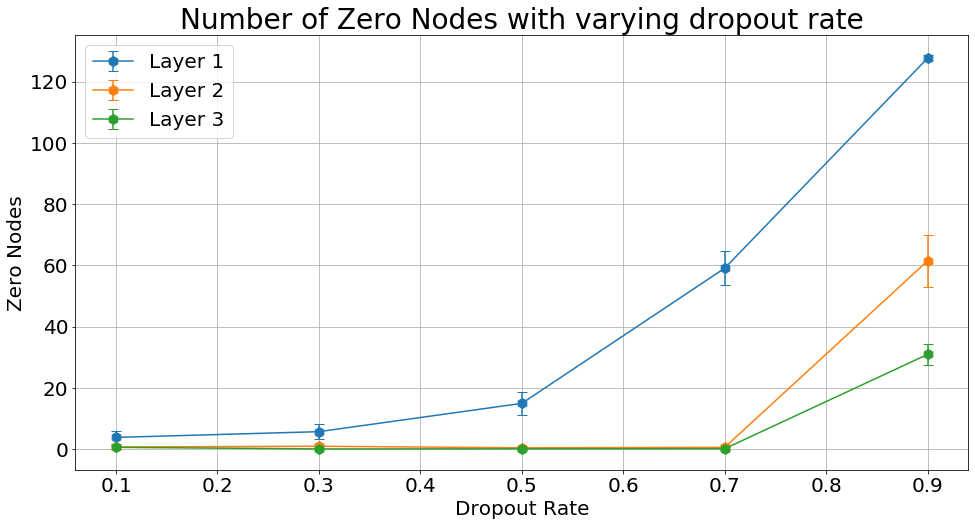

In [47]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/zero_nodes_MLP_dropout_mnist.png")

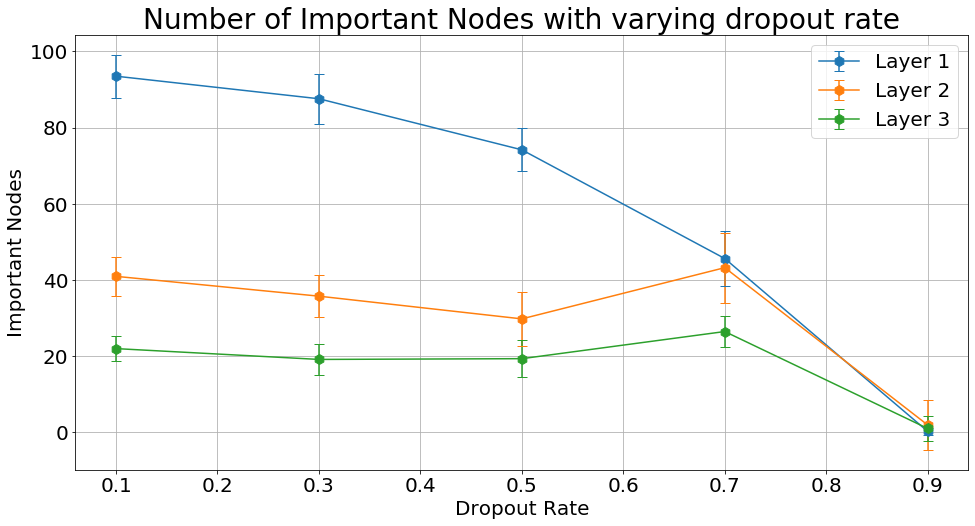

In [48]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/imp_nodes_MLP_dropout_mnist.png")

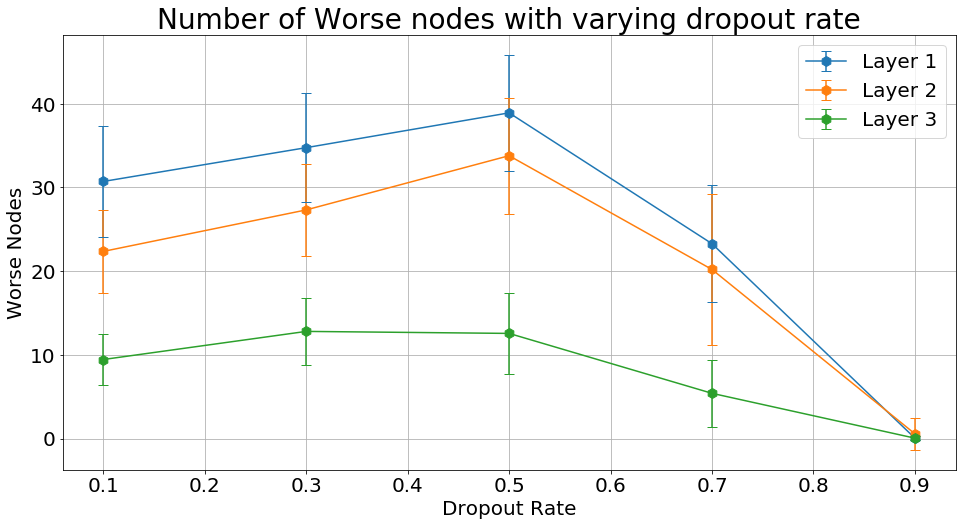

In [49]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/worse_nodes_MLP_dropout_mnist.png")

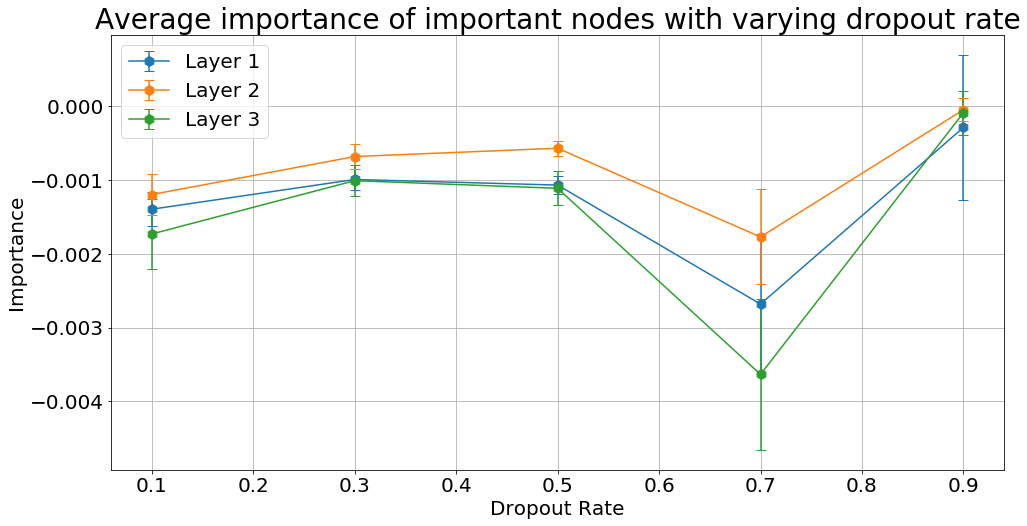

In [50]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/avg_imp_nodes_MLP_dropout_mnist.png")

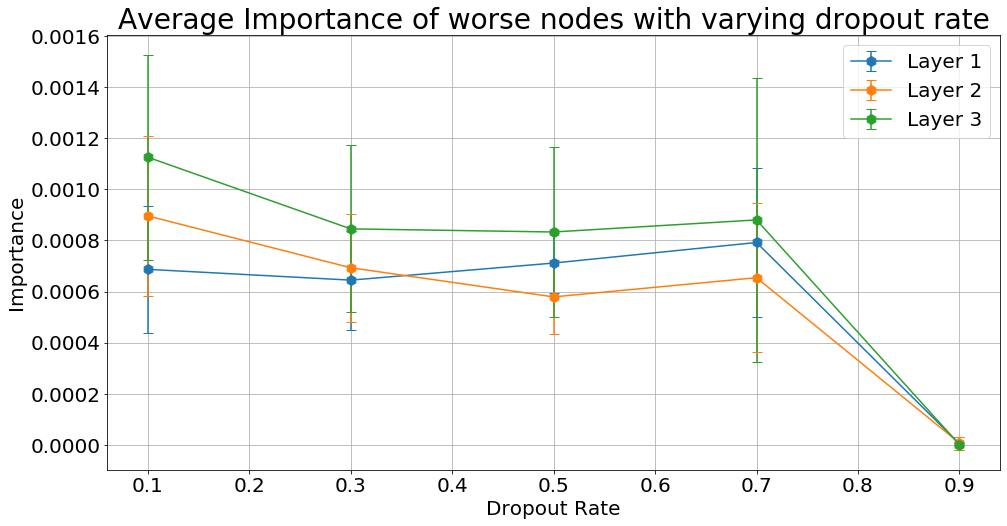

In [51]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/avg_worse_nodes_MLP_dropout_mnist.png")

### Fashion MNIST

In [52]:
np.random.seed(2020)

In [53]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [54]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [55]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
dropout_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
node_importance = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
accs = np.zeros((trials, len(dropout_rate)))
losses = np.zeros((trials, len(dropout_rate)))
avg_node_imp = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
for b, rate in enumerate(dropout_rate):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [09:28<00:00, 22.74s/it]


In [73]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_1 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/dropout/node_imp_MLP_dropout_1_fmnist.csv')
NI_1.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean   20.440000   23.800000       83.760000  30.080000   25.800000   
std     3.083288    6.013873        6.685058   3.377869    5.008326   
min    15.000000   13.000000       71.000000  21.000000   16.000000   
25%    18.000000   19.000000       80.000000  28.000000   23.000000   
50%    21.000000   23.000000       83.000000  31.000000   27.000000   
75%    22.000000   29.000000       89.000000  32.000000   29.000000   
max    28.000000   35.000000       94.000000  34.000000   35.000000   

                             0.5                                     0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes  Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000   25.000000   
mean        72.120000  47.080000   21.560000       59.360000   88.400000   
std          5.286145   5.529617    7.292005        8.082285    9.591663   
min         65.000000  34.000000    9.000000       45.000000   77.000000   
25%         67.000000  43.000000   16.000000       52.000000   83.000000   
50%         72.000000  47.000000   20.000000       61.000000   85.000000   
75%         76.000000  51.000000   27.000000       65.000000   90.000000   
max         81.000000  57.000000   36.000000       76.000000  111.000000   

                                          0.9                              
      Worse Nodes Important Nodes  Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000   25.000000   25.000000       25.000000  
mean     3.080000       36.520000  123.960000    0.320000        3.720000  
std      3.121431        9.188398    4.894555    0.852447        4.373404  
min      0.000000       14.000000  112.000000    0.000000        0.000000  
25%      1.000000       33.000000  122.000000    0.000000        0.000000  
50%      2.000000       39.000000  126.000000    0.000000        2.000000  
75%      3.000000       43.000000  128.000000    0.000000        6.000000  
max     11.000000       45.000000  128.000000    4.000000       15.000000

In [74]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/dropout/avg_node_imp_MLP_dropout_1_fmnist.csv')
AvgNI_1.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -2.476511e-08    0.001190       -0.001854 -1.410101e-07    0.000888   
std    4.764995e-07    0.000862        0.000262  2.888021e-07    0.000413   
min   -8.059045e-07    0.000326       -0.002480 -6.466201e-07    0.000413   
25%   -4.441965e-07    0.000746       -0.001928 -3.136340e-07    0.000550   
50%   -1.761046e-08    0.000970       -0.001808 -1.302472e-07    0.000857   
75%    3.524449e-07    0.001349       -0.001684  1.676381e-08    0.000944   
max    8.165836e-07    0.004448       -0.001411  6.818410e-07    0.002405   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.001608  6.703296e-08    0.000830       -0.001841 -4.393905e-08   
std          0.000130  1.835728e-07    0.000365        0.000300  8.375862e-08   
min         -0.001875 -2.594555e-07    0.000188       -0.002445 -1.986821e-07   
25%         -0.001677 -4.940911e-08    0.000585       -0.002001 -1.126593e-07   
50%         -0.001599  3.049540e-08    0.000783       -0.001833 -1.648639e-08   
75%         -0.001534  1.087523e-07    0.000996       -0.001585  1.561074e-08   
max         -0.001359  5.452072e-07    0.001970       -0.001346  1.039616e-07   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000740       -0.005089 -3.928679e-08    0.000022       -0.000622  
std      0.001952        0.003933  5.428737e-08    0.000077        0.000865  
min      0.000000       -0.016389 -1.394143e-07    0.000000       -0.002529  
25%      0.000060       -0.005884 -8.207853e-08    0.000000       -0.001212  
50%      0.000223       -0.004390 -2.955602e-08    0.000000       -0.000119  
75%      0.000487       -0.002019  0.000000e+00    0.000000        0.000000  
max      0.009833       -0.001231  6.012295e-08    0.000379        0.000000

In [75]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_2 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/dropout/node_imp_MLP_dropout_2_fmnist.csv')
NI_2.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean    0.760000   18.600000       44.640000   0.680000   21.520000   
std     0.879394    5.196152        5.368737   0.852447    5.447629   
min     0.000000    7.000000       36.000000   0.000000   13.000000   
25%     0.000000   14.000000       41.000000   0.000000   16.000000   
50%     1.000000   18.000000       45.000000   0.000000   22.000000   
75%     1.000000   23.000000       48.000000   1.000000   26.000000   
max     3.000000   27.000000       57.000000   3.000000   31.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000    25.00000       25.000000   25.00000   
mean        41.800000   0.280000    19.08000       44.640000    1.08000   
std          5.392897   0.541603     6.26445        6.177108    1.28841   
min         33.000000   0.000000     7.00000       32.000000    0.00000   
25%         38.000000   0.000000    15.00000       40.000000    0.00000   
50%         41.000000   0.000000    19.00000       45.000000    1.00000   
75%         46.000000   0.000000    23.00000       48.000000    2.00000   
max         51.000000   2.000000    32.00000       56.000000    4.00000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000        25.00000  25.000000   25.000000       25.000000  
mean     2.680000        60.24000  44.080000    4.600000       15.320000  
std      5.662155         6.44386  20.448961    4.958158       16.275544  
min      0.000000        40.00000   8.000000    0.000000        0.000000  
25%      0.000000        61.00000  21.000000    0.000000        0.000000  
50%      0.000000        63.00000  54.000000    4.000000        8.000000  
75%      2.000000        64.00000  64.000000    7.000000       29.000000  
max     20.000000        64.00000  64.000000   19.000000       46.000000

In [76]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/dropout/avg_node_imp_MLP_dropout_2_fmnist.csv')
AvgNI_2.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -5.223354e-07    0.001341       -0.001807  9.904305e-07    0.000933   
std    3.989913e-06    0.000782        0.000426  3.837706e-06    0.000371   
min   -9.059906e-06    0.000255       -0.003083 -6.064773e-06    0.000487   
25%   -1.758337e-06    0.000880       -0.002001  0.000000e+00    0.000665   
50%    0.000000e+00    0.001177       -0.001722  0.000000e+00    0.000887   
75%    0.000000e+00    0.001411       -0.001571  3.516674e-06    0.001077   
max    9.775162e-06    0.003892       -0.001161  7.480383e-06    0.002237   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.001271  3.725290e-07    0.000677       -0.001261 -6.337961e-07   
std          0.000188  1.891381e-06    0.000251        0.000151  1.948187e-06   
min         -0.001792 -4.649162e-06    0.000282       -0.001644 -5.125999e-06   
25%         -0.001382  0.000000e+00    0.000508       -0.001312 -1.609325e-06   
50%         -0.001293  0.000000e+00    0.000652       -0.001261  0.000000e+00   
75%         -0.001187  0.000000e+00    0.000817       -0.001155  0.000000e+00   
max         -0.000960  5.900860e-06    0.001452       -0.000951  3.735224e-06   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000069       -0.002113 -2.182321e-07    0.000047       -0.000173  
std      0.000156        0.001083  4.071101e-07    0.000059        0.000251  
min      0.000000       -0.003942 -1.460314e-06    0.000000       -0.000792  
25%      0.000000       -0.002982 -3.652370e-07    0.000000       -0.000281  
50%      0.000000       -0.002295 -1.362392e-07    0.000023       -0.000035  
75%      0.000053       -0.001024  0.000000e+00    0.000083        0.000000  
max      0.000701       -0.000594  5.505302e-07    0.000247        0.000000

In [77]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_3 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/dropout/node_imp_MLP_dropout_3_fmnist.csv')
NI_3.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count      25.00    25.00000       25.000000  25.000000   25.000000   
mean        0.36     6.60000       25.040000   0.160000    6.720000   
std         0.70     3.21455        3.284814   0.374166    3.323151   
min         0.00     0.00000       18.000000   0.000000    2.000000   
25%         0.00     4.00000       23.000000   0.000000    5.000000   
50%         0.00     6.00000       25.000000   0.000000    6.000000   
75%         1.00     9.00000       28.000000   0.000000    9.000000   
max         3.00    14.00000       32.000000   1.000000   15.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000       25.0   
mean        25.120000   0.160000    4.920000       26.920000        0.0   
std          3.270066   0.374166    2.722132        2.722132        0.0   
min         17.000000   0.000000    0.000000       20.000000        0.0   
25%         23.000000   0.000000    3.000000       26.000000        0.0   
50%         26.000000   0.000000    5.000000       27.000000        0.0   
75%         27.000000   0.000000    6.000000       29.000000        0.0   
max         30.000000   1.000000   12.000000       32.000000        0.0   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000       25.0       25.00       25.000000  
mean     0.360000       31.640000       23.8        0.08        8.120000  
std      1.220656        1.220656        8.5        0.40        8.569909  
min      0.000000       26.000000        8.0        0.00        0.000000  
25%      0.000000       32.000000       16.0        0.00        0.000000  
50%      0.000000       32.000000       28.0        0.00        4.000000  
75%      0.000000       32.000000       32.0        0.00       16.000000  
max      6.000000       32.000000       32.0        2.00       24.000000

In [78]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/dropout/avg_node_imp_MLP_dropout_3_fmnist.csv')
AvgNI_3.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -2.038479e-07    0.001636       -0.003322  3.409386e-07    0.001158   
std    2.466531e-06    0.001363        0.000581  3.046101e-06    0.000634   
min   -8.434057e-06    0.000000       -0.004489 -9.417534e-06    0.000193   
25%    0.000000e+00    0.000811       -0.003661  0.000000e+00    0.000666   
50%    0.000000e+00    0.001267       -0.003152  0.000000e+00    0.001150   
75%    0.000000e+00    0.001888       -0.002921  0.000000e+00    0.001547   
max    7.599592e-06    0.006348       -0.002296  8.970499e-06    0.002418   

                                0.5                                    0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000       25.0   
mean        -0.002605 -4.827976e-07    0.000776       -0.003074        0.0   
std          0.000583  2.520235e-06    0.000356        0.000459        0.0   
min         -0.003921 -9.387732e-06    0.000000       -0.004021        0.0   
25%         -0.003079  0.000000e+00    0.000522       -0.003399        0.0   
50%         -0.002623  0.000000e+00    0.000752       -0.002991        0.0   
75%         -0.002194  0.000000e+00    0.000994       -0.002751        0.0   
max         -0.001687  5.096197e-06    0.001551       -0.002245        0.0   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000056       -0.004687 -2.892159e-07    0.000004       -0.000301  
std      0.000199        0.002304  3.230670e-07    0.000022        0.000459  
min      0.000000       -0.007846 -1.285387e-06    0.000000       -0.001452  
25%      0.000000       -0.006649 -3.278255e-07    0.000000       -0.000519  
50%      0.000000       -0.004885 -2.301972e-07    0.000000       -0.000054  
75%      0.000000       -0.002591 -2.980232e-08    0.000000        0.000000  
max      0.000918       -0.001361  0.000000e+00    0.000109        0.000000

In [79]:
A = pd.DataFrame(accs, columns=dropout_rate)
A.to_csv('../../../results/dropout/avg_acc_MLP_dropout_fmnist.csv')
A.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.867200,0.855164,0.808224,0.552544,0.113496
std,0.004277,0.004003,0.019791,0.074222,0.018734
min,0.857500,0.843300,0.744000,0.445900,0.100000
25%,0.864500,0.853200,0.800700,0.486900,0.100000
50%,0.867500,0.856800,0.807100,0.550100,0.102000
75%,0.870300,0.858100,0.820900,0.608400,0.128300
max,0.874200,0.859200,0.830800,0.687100,0.151800


In [80]:
L = pd.DataFrame(losses, columns=dropout_rate)
L.to_csv('../../../results/dropout/loss_MLP_dropout_fmnist.csv')
L.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.368473,0.404293,0.512505,1.133286,2.295879
std,0.011311,0.008219,0.024724,0.117349,0.012253
min,0.354510,0.390243,0.464839,0.889144,2.260974
25%,0.360504,0.398425,0.496673,1.066774,2.294504
50%,0.366087,0.403157,0.507159,1.104451,2.302472
75%,0.373900,0.408587,0.531358,1.249127,2.302634
max,0.403704,0.421315,0.556877,1.316099,2.302698


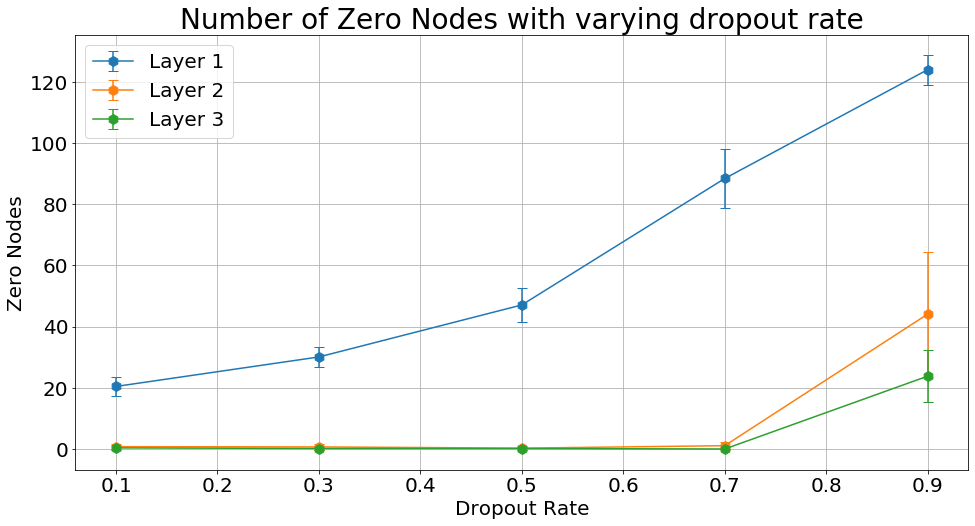

In [81]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/zero_nodes_MLP_dropout_fmnist.png")

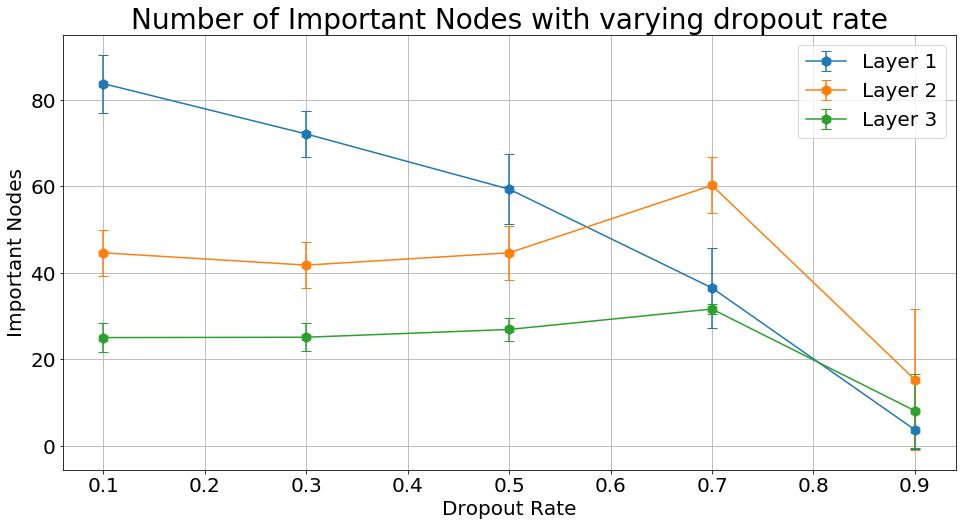

In [82]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/imp_nodes_MLP_dropout_fmnist.png")

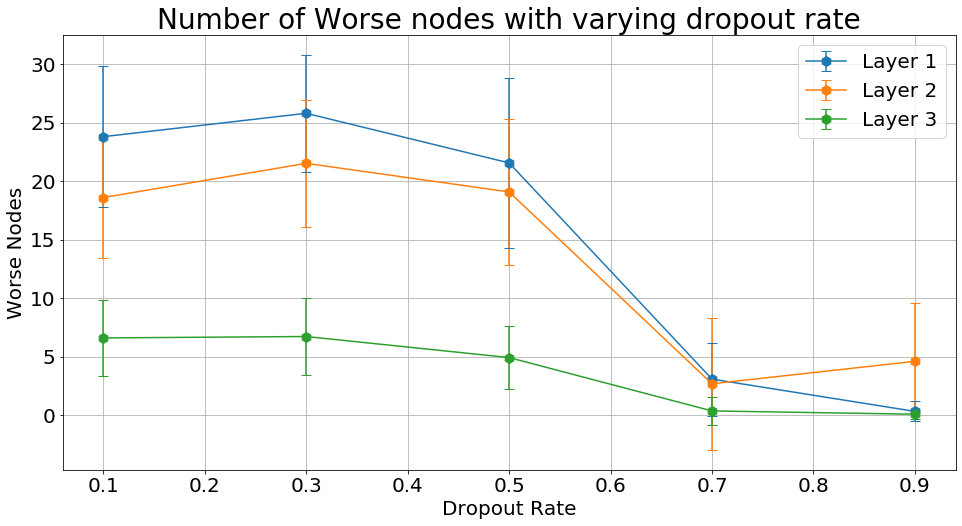

In [83]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/worse_nodes_MLP_dropout_fmnist.png")

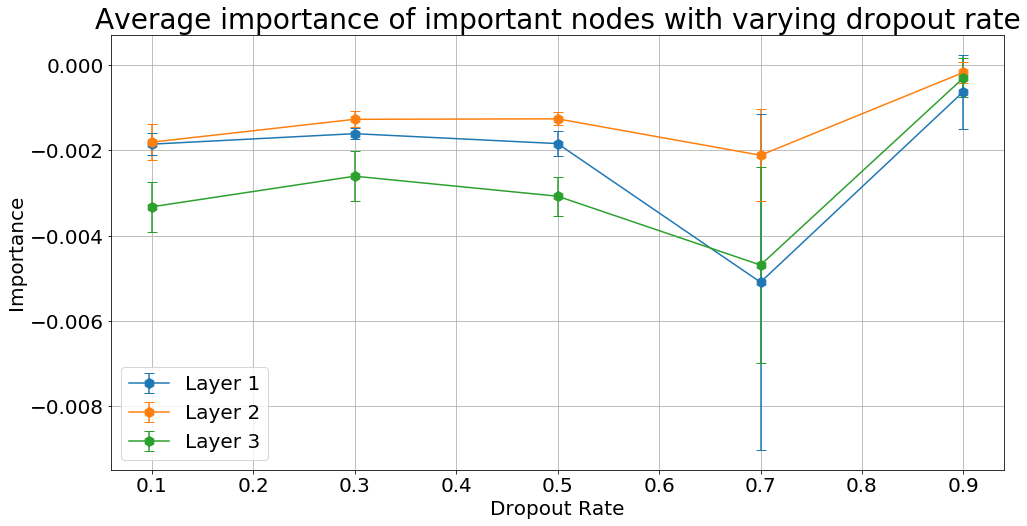

In [84]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/avg_imp_nodes_MLP_dropout_fmnist.png")

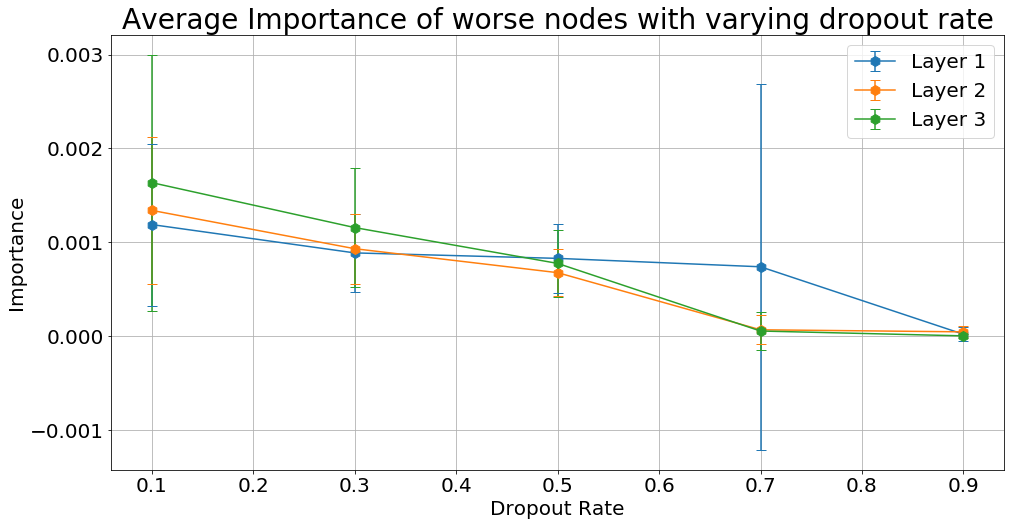

In [85]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/dropout/avg_worse_nodes_MLP_dropout_fmnist.png")